In [1]:
import random

import numpy as np
import math
from scipy.optimize import minimize
from sympy import *
from joblib import Parallel, delayed
from sympy.logic.boolalg import truth_table


x,y,z,w = symbols('x,y,z,w')



In [2]:
def extract_data_from_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:
                parts = line.split(',')
                if len(parts) == 3:
                    data_point = {
                        'value1': float(parts[0]),
                        'value2': float(parts[1]),
                        'expression': parts[2]
                    }
                    data.append(data_point)
                else:
                    print("La ligne ne contient pas le bon nombre de parties:", line)
    return data

def find_max_difference(data):
    max_difference = float('-inf')  # Initialisation avec une valeur très basse
    max_difference_line = None

    for d in data:
        difference = abs(d['value1'] - d['value2'])
        if difference > max_difference:
            max_difference = difference
            max_difference_line = d

    return max_difference_line



def game_score(data):
    
    score = 0
    for d in data:
        difference = abs(d['value1'] - d['value2'])
        if difference > 0.01 and d['value1'] > d['value2']:
            score+=1
    
    score = score/4240
    return score


def mean_gap(data):
    r = []

    for d in data:
        difference = abs(d['value1'] - d['value2'])
        if difference > 0.01 and d['value1'] > d['value2']:
            r.append(difference)
    return sum(r)/len(r)


# Functions Definition

In [ ]:

import random

import numpy as np
import math
from scipy.optimize import minimize

# Number of players, number of answers, number of qubits
n = 4
# Number of possible basis states
two_power_n = 2 ** n


def generate_all_functions_Bn_to_B():
    """Generate all the binary functions from B_n = {0,1}^n to B = {0,1}
    Returns:
        an array containing all possible functions in binary representation
    """
    tab = []
    for i in range(2 ** two_power_n):
        tab.append(integer_to_binary_tab(i, two_power_n))
    return tab


def generate_all_functions_Bn_to_Bn():
    """Generate all the binary functions from B_n = {0,1}^n to B_n
    Returns:
        an array containing all possible functions in binary representation
    """
    tab = []
    for i in range(2 ** (2 * n)):
        tab.append(np.array_split(integer_to_binary_tab(i, 2 * n), n))
    return tab


def evaluate_function(f, f_variables):
    """ Evaluate a binary function on a specific set of binary variables
    Arguments:
        f: binary representation of the function to evaluate
        f_variables: vector of binary variables
    """
    # print(f_variables)
    # print(int(binary_tab_to_integer(f_variables)))
    return f[binary_tab_to_integer(f_variables)]

def evaluate(f):
    r = []
    for k in range(2**n):
        if evaluate_function(f,integer_to_binary_tab(k,n))==1:
            r.append(integer_to_binary_tab(k,n))
    return r

def evaluate_function_strategy(h, h_variables):
    """
    Arguments:
        h: binary representation of the strategy function to evaluate
        h_variables: vector of binary variables
    """

    return [h[k][h_variables[k]] for k in range(len(h_variables))]


def evaluate_problem(f, g, f_variables, g_variables):
    """ Evaluate the problem equation with the inputs
    Arguments:
        f: binary function representing the left-hand side of the problem's equation
        g: binary function representing the right-hand side of the problem's equation
        f_variables: vector of binary variables to evaluate f
        g_variables: vector of binary variables to evaluate g
    Returns:
        True if the equation given by f and g is satisfied, False otherwise
    """
    if evaluate_function(f, f_variables) == evaluate_function(g, g_variables):
        return 1
    return 0


def compute_score_classical_strategy(h, f, g):
    """ Computes the score of the classical strategy h for the problem given by (f,g)
    Arguments:
        h: strategy
        f: binary function representing the left-hand side of the problem's equation
        g: binary function representing the right-hand side of the problem's equation
    """
    somme = 0
    for i in range(two_power_n):
        param = integer_to_binary_tab(i, n)
        somme = somme + evaluate_problem(f, g, param, evaluate_function_strategy(h, param))
    score = somme / (two_power_n * 1.0)
    return score


def find_best_classical_strategies(f: list, g: list):
    """ Find the best classical strategy for the CHSH game defined by the inputs
    Arguments:
        f: defines the boolean equation with the referee questions
        g: defines the boolean equation with players answers
    Returns:
        best_score: the highest probability of winning the for the best classical strategy
        best_strategies: the strategies (deterministic description of the answers) that reach the best score
    """
    best_score = 0
    best_strategies = []
    all_classical_strategies = generate_all_functions_Bn_to_Bn()
    for index in range(len(all_classical_strategies)):
        test_score = compute_score_classical_strategy(all_classical_strategies[index], f, g)
        if test_score == best_score:
            best_strategies.append(all_classical_strategies[index])
        elif test_score > best_score:
            best_score = test_score
            best_strategies = [all_classical_strategies[index]]
    return best_score, best_strategies


### QUANTUM STRATEGIES ###


def construct_unitary_matrix(angles):
    """ Return a unitary matrix from the angles in parameter
        Arguments:
            angles : array of angles describing the angles of the unitary rotation
        """
    theta = angles[0]
    phi = angles[1]
    lambdaa = angles[2]
    return [[math.cos(theta / 2),                          -np.exp(lambdaa * 1j) * math.sin(theta / 2)],
            [np.exp(phi * 1j) * math.sin(theta / 2),        np.exp((phi + lambdaa) * 1j) * math.cos(theta / 2)]]


def apply_player_strategy(player_index, angles, state):
    """ Applies a rotation to the qubit owned by the player_index-th player.
    This rotation of the state models the local rotation of the local measurement basis of the corresponding player
    Args:
        player_index: integer representing the index of the player in the game
        angles: array of angles describing the player's new local basis where to measure this part of the state
        state: vector representing the quantum state shared by the players
    Returns:
        succeeded: a boolean indicating whether the function was successfully applied or not
    """
    state_copy = state.copy()

    identity_matrix = np.identity(2)
    rotation_matrix = construct_unitary_matrix(angles)

    global_matrix = 1
    for _ in range(0, player_index):
        global_matrix = np.kron(global_matrix, identity_matrix)
    global_matrix = np.kron(global_matrix, rotation_matrix)
    for _ in range(player_index + 1, n):
        global_matrix = np.kron(global_matrix, identity_matrix)

    return global_matrix.dot(state_copy)


def get_probabilities(state):
    """ Retrieve the probabilities associated with the input state
    Args:
        state: array representing the vector in the Hilbert space
    Returns:
        tab: an array containing all the probabilities associated
              with each amplitude of the state
    """
    return [abs(state[i])**2 for i in range(len(state))]


def evaluate_quantum_strategy_for_question(angles_array, state, f, g, f_variables):
    """ Evaluate the gain probability for the given set of angles for each player
        with respect to the question answered by the referee
    Arguments:
        angles_array: a 3D-array containing the the rotations angles,
                       for each question of the referee,
                       for each player of the game
        state: vector representing the quantum state shared by the players
        f: defines the boolean equation with the referee questions
        g: defines the boolean equation with players answers
        f_variables: the question given by the referee
    """
    state_copy = state.copy()
    # for each player, apply his quantum strategy
    for i in range(n):
        state_copy = apply_player_strategy(i, angles_array[i][f_variables[i]], state_copy)

    probas = get_probabilities(state_copy)

    somme = 0
    for i in range(two_power_n):
        param = integer_to_binary_tab(i, n)
        somme = somme + probas[i] * evaluate_problem(f, g, f_variables, param)

    return somme


def evaluate_quantum_strategy(angles_array, state, f, g):
    """ Evaluate the gain probability for the given set of angles for each player
        by computing the average gain for each question
    Args:
        angles_array: array containing the angles representing the strategy
        state: vector representing the quantum state shared by the players
        f: defines the boolean equation with the referee questions
        g: defines the boolean equation with players answers
    """
    somme = 0
    for i in range(two_power_n):
        param = integer_to_binary_tab(i, n)
        somme = somme + evaluate_quantum_strategy_for_question(angles_array, state, f, g, param)
    score = somme / (two_power_n * 1.0)
    return score


def find_best_quantum_strategy(f, g, state):
    """ Use a classical optimizer to find the best angles defining the quantum strategy
    Arguments:
        f: defines the boolean equation with the referee questions
        g: defines the boolean equation with players answers
        state: vector representing the quantum state shared by the players
    """
    # for n players, 2 basis, and 3 angles
    init_angles = np.array([np.random.rand() * 2 * math.pi for _ in range(n * 2 * 3)])

    def function_to_optimize(angles_flat):
        angles_not_flat = np.reshape(angles_flat, (n, 2, 3))
        return 1 - evaluate_quantum_strategy(angles_not_flat, state, f, g)

    def callback(param_list):
        current_E = 1 - function_to_optimize(param_list)
        #print("current gain:", current_E)
        return None

    method = "BFGS"
    options_2 = {'disp': False, 'maxiter': 150, 'gtol': 1e-5}
    #options_2 = {'disp': False, 'maxiter': 400}
    opt = minimize(function_to_optimize, init_angles, method=method, options=options_2, callback=callback)
    return opt


def interesting_problem(f: list, g: list) -> bool:
    """ Determine if the problem define by f and g is interesting for us
    It should verify that :
        1. All players should have a question and an answer involved in both sides of the equation
        2. The left and right side of the equation are different
    Arguments:
        f: defines the boolean equation with the referee questions
        g: defines the boolean equation with players answers
    """
    if f == g:
        return False

    nb_one_f = f.count(1)
    nb_one_g = g.count(1)
    if n == 2:
        if nb_one_f * nb_one_g == 0 or nb_one_f == two_power_n or nb_one_g == two_power_n \
                or nb_one_f == n or nb_one_g == n:
            return False
        else:
            return True
    if n == 3:
        non_useful_cases = [0, 3, 5, 10, 12, 15, 17, 34, 48, 51, 60, 63, 68, 80, 85, 90, 95, 102, 119, 136, 153, 160,
                            165, 170, 175, 187, 192, 195, 204, 207, 221, 238, 240, 243, 245, 250, 252, 255]
        binary_table_non_useful_cases = [integer_to_binary_tab(non_useful_cases[i], two_power_n)
                                         for i in range(len(non_useful_cases))]
        if (f in binary_table_non_useful_cases) or (g in binary_table_non_useful_cases):
            return False
        else:
            return True


def integer_to_binary_tab(integer: int, size: int) -> list[int]:
    binary = format(integer, 'b')
    tab = [0] * size
    length = len(binary)
    for i in range(length):
        tab[size - length + i] = int(binary[i])
    return tab


def binary_tab_to_integer(binary_tab):
    size = len(binary_tab)
    return int(sum(binary_tab[size - i - 1] * 2 ** i for i in range(size)))


def normalize(v):
    """ 
    Normalize the vector given in parameter (norm 2)
    Args:
        v: vector, represented by a list or an array
    """
    norm = np.linalg.norm(v, ord=2)
    if norm == 0:
        return v
    else:
        return v / norm


def expression_to_truth_table(expression):
    r=[]
    table = list(truth_table(expression, [w, x, y, z]))

    for k in table :
        r.append(int(k[1]==True))

    return r


def bool_expr(f):
    minterms = evaluate(f)
    expr = SOPform([w, x, y, z], minterms)
    return expr


def is_interesting(f):
    minterms = evaluate(f)
    bool_expression = SOPform([w, x, y, z], minterms)
    str_bool_expr = str(bool_expression)
    if str_bool_expr.find('w') != -1 and str_bool_expr.find('x') != -1  and str_bool_expr.find('y') != -1  and str_bool_expr.find('z') != -1 :
        return True
    else:
        return False







def generate_ghz(n):
    ghz_n_state = [0] * (2**n)
    ghz_n_state[0] = 1
    ghz_n_state[-1] = 1
    ghz_n_state = normalize(ghz_n_state)
    return ghz_n_state

ghz_4_state = generate_ghz(4)


### 4 qubits States

In [42]:
def gabcd(a,b,c,d):
    g = [0] * 16
    g[0] = ((a+d)/2)
    g[15] = ((a+d)/2)
    g[3] = ((a-d)/2)
    g[12] = ((a-d)/2)
    g[5] = (b+c)/2
    g[10] = (b+c)/2
    g[6] = (b-c)/2
    g[9]=(b-c)/2

    g=normalize(g)

    return g

def Labc2(a,b,c):
    g = [0] *16
    g[0] = (a+b)/2
    g[-1] = (a+b)/2
    g[3] = (a-b)/2
    g[12] = (a-b)/2
    g[5] = c
    g[10] = c
    g[6] = 1

    g=normalize(g)

    return g


def La2b2(a,b):
    g = [0] *16

    g[0] = a
    g[15] = a

    g[5] = b
    g[10] = b

    g[6] = 1
    g[3] = 1

    g=normalize(g)
    return g


def La2031(a):
    g = [0] *16
    g[0] = a
    g[15] = a
    g[3] = 1
    g[5] = 1
    g[6] = 1
    g=normalize(g)
    return g

def L053():
    g = [0] *16
    g[0] = 1
    g[5] = 1
    g[8] = 1
    g[14] = 1

    g=normalize(g)
    return g

def L071():
    g = [0] *16
    g[0] = 1
    g[11] = 1
    g[13] = 1
    g[14] =1 

    g=normalize(g)
    return g

def L3131():
    g = [0] *16
    g[0] = 1
    g[7] = 1

    g=normalize(g)
    return g

def Lab3(a,b):
    g = [0] *16
    g[0] = a
    g[15] = a

    g[5] = (a+b)/2
    g[10] = (a+b)/2

    g[6] = (a-b)/2
    g[9] = (a-b)/2

    g[1] = 1j/math.sqrt(2)
    g[2] = 1j/math.sqrt(2)
    g[14] = -1j/math.sqrt(2)
    g[13] = -1j/math.sqrt(2)


    g=normalize(g)
    return g


def La4(a):
    g = [0] *16

    g[0] = a
    g[5] = a
    g[10] = a
    g[15] = a

    g[1] = 1j
    g[6] = 1

    g[11] = 1j

    g=normalize(g)
    return g



def MP():
    g = [0] *16

    g[0] = 1
    g[3] = 1
    g[12] = 1
    g[15] = 1

    g = normalize(g)
    return g

def C1():
    g = [0] *16

    g[0] = 1
    g[3] = 1
    g[12] = 1
    g[15] = -1

    g = normalize(g)
    return g

def C2():
    g = [0] *16

    g[0] = 1
    g[6] = 1
    g[9] = 1
    g[15] = -1

    g = normalize(g)
    return g

def L_state():
    w = np.exp((2*np.pi*1j)/3)

    g = [0] *16
    
    g[0] = (1+w)
    g[15] = (1+w)
    
    g[3] = (1-w)
    g[12] = (1-w)

    g[5] = w**2
    g[6] = w**2
    g[9] = w**2
    g[10] = w**2

    g = normalize(g)
    return g


def HS():
    w = np.exp((2*np.pi*1j)/3)

    g = [0] *16
    
    g[3]=1
    g[12] = 1

    g[5]=w
    g[10]=w
    
    g[9]=w**2
    g[6]=w**2


    g = normalize(g)
    return g









w_state = [0] * 16
w_state[1] = 1
w_state[2] = 1
w_state[4] = 1
w_state[8] = 1

w_state = normalize(w_state)


# Parrallel Data Processing

In [ ]:
#### TEST FOR 4-qubit CHSH GAME



def process_data(chsh_g, ghz_4, t):
    best_quantum = find_best_quantum_strategy(t, chsh_g, ghz_4)
    score_quantum = 1 - best_quantum.fun

    

    score, strategies = find_best_classical_strategies(t, chsh_g)
    

    if score < score_quantum :
        """
        print("Classical score : ",score)
        print("Quantum score : ",score_quantum)
        print("Function : ",bool_expr(t))
        print("***********\n")
        """
        return (score_quantum, score,t)
    else:
        return None
    
def multi_parallel(tab,g,etat):
    chsh_g = g
    ghz_4 = etat
    results = Parallel(n_jobs=-1)(delayed(process_data)(chsh_g, ghz_4, t) for t in tab)

    for result in results:
        if result:
            print("\n\n\n\n*******************************************")
            score_quantum, score ,t= result
            pprint(SOPform([w, x, y, z], evaluate(t)))
            print("Best quantum with g 1:", score_quantum)
            print("Best classical with g1:", score,"\n")
            print("----------------")
    return results


In [5]:
chsh_f_ = [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
chsh_g = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]

best_quantum = find_best_quantum_strategy(chsh_f_, chsh_g, ghz_4_state)
score_quantum = 1 - best_quantum.fun
           
minterms = evaluate(chsh_f_) 
print(SOPform([w, x, y, z], minterms))
print("Best quantum :", score_quantum)
score,strategies = find_best_classical_strategies(chsh_f_, chsh_g)
print("Best classical :", score)
print("----------------")
print(len(strategies))



(x & y & ~w) | (y & z & ~w) | (w & ~x & ~y & ~z)
Best quantum : 0.8266407409553408
Best classical : 0.75
----------------
16


# All Boolean functions (4 bits)


In [ ]:
all_f = generate_all_functions_Bn_to_B()


from itertools import product

def extract_variables(expression):
    variables = set()
    for char in expression:
        if char.isalpha():
            variables.add(char)
    return variables

def generate_variants(expression):
    r=[]
    variables = extract_variables(expression)
    negation_options = ['~', '']

    for combination in product(negation_options, repeat=len(variables)):
        variant = expression
        for variable, negation in zip(sorted(variables), combination):
            variant = variant.replace(variable, negation + variable)
        r.append(variant)
    return r


def generate_variants2(expression):
    r=[]
    r2=[]
    variables = extract_variables(expression)
    negation_options = ['~', '']

    for combination in product(negation_options, repeat=len(variables)):
        variant = expression
        for variable, negation in zip(sorted(variables), combination):
            variant = variant.replace(variable, negation + variable)
        r.append(variant)
    for t in r:
        r2.append(expression_to_truth_table(t))
    return r2
# Exemple d'utilisation
test=generate_variants2("w & x & z & ~y")





print(test)

def formatage(test):
    space = []
    new = []
    for t in test:
            new.append(t.replace("~~",""))
    """
    for n in new[:10]:
        chaine_avec_espace = ""
        for char in n:
            if char in ['&', '|']:
                chaine_avec_espace += " " + char + " "
            else:
                chaine_avec_espace += char
        space.append(chaine_avec_espace)

    """
    space = new
    return space

expr_f = []

for f in  all_f:
    new_f = str(bool_expr(f))
    expr_f.append(new_f)


r=all_f
new = []
for k in r:
    expression = bool_expr(k)
    not_expr = Not(expression)
    #print(expression_to_truth_table(not_expr))

    if expression_to_truth_table(not_expr) not in new:
        new.append(k)

new2 = new

expr_f = []

for f in  new2:
    new_f = str(bool_expr(f))
    expr_f.append(new_f)


i = 1
while i < len(expr_f) - 1 and i < len(new2) - 1:
    f = expr_f[i]
    t = new2[i]
    test = generate_variants2(f)
    
    for variantes in test[:-1]:
        if variantes in new2:
            new2.remove(variantes)
            expr_f.remove(str(bool_expr(variantes)))
    print(len(new2),i,end="\r")
    i += 1



all_f_interesting = []

for f in new2:
    #score,strategies = find_best_classical_strategies(f, chsh_g)
    if is_interesting(f):
        all_f_interesting.append(f)






In [ ]:

chsh_g = expression_to_truth_table((w&x&y&z)|(w&x&~y&~z)|(~w&~x&y&z)|(~w&~x&~y&~z))
resultat_GHZ = multi_parallel(all_f_interesting,chsh_g,MP())





*******************************************
(w ∧ x ∧ ¬y) ∨ (y ∧ z ∧ ¬w) ∨ (w ∧ y ∧ ¬x ∧ ¬z)
Best quantum with g 1: 0.7085698316498427
Best classical with g1: 0.6875 

----------------




*******************************************
(y ∧ z ∧ ¬w) ∨ (w ∧ x ∧ ¬y ∧ ¬z) ∨ (w ∧ y ∧ ¬x ∧ ¬z) ∨ (w ∧ z ∧ ¬x ∧ ¬y)
Best quantum with g 1: 0.7085698302317777
Best classical with g1: 0.6875 

----------------




*******************************************
(w ∧ x ∧ ¬y) ∨ (w ∧ z ∧ ¬y) ∨ (x ∧ y ∧ ¬w) ∨ (y ∧ z ∧ ¬w) ∨ (w ∧ y ∧ ¬x ∧ ¬z)
Best quantum with g 1: 0.693629761503597
Best classical with g1: 0.6875 

----------------




*******************************************
(w ∧ x ∧ ¬y) ∨ (w ∧ z ∧ ¬y) ∨ (x ∧ y ∧ z) ∨ (x ∧ y ∧ ¬w) ∨ (y ∧ z ∧ ¬w) ∨ (w ∧
 y ∧ ¬x ∧ ¬z)
Best quantum with g 1: 0.6397542474591865
Best classical with g1: 0.625 

----------------




*******************************************
(w ∧ x ∧ ¬z) ∨ (w ∧ z ∧ ¬x ∧ ¬y) ∨ (x ∧ z ∧ ¬w ∧ ¬y) ∨ (y ∧ z ∧ ¬w ∧ ¬x)
Best quantum with g 1: 0.7085

In [30]:
with open("MP_sep2.txt", "a") as f:
    #f.write("Nouvelles données à ajouter dans le fichier.\n")
    for result in resultat_GHZ:
            if result:
                #print("\n\n\n\n*******************************************")
                score_quantum, score ,t= result
                #pprint(SOPform([w, x, y, z], evaluate(t)))
                #print("Best quantum with g1:", score_quantum)
                #print("Best classical with g1:", score,"\n")
                #print("----------------")
                # Convertir les variables en chaînes de caractères si nécessaire
                score_quantum_str = str(score_quantum)
                score_str = str(score)
                sop_form_str = str(SOPform([w, x, y, z], evaluate(t)))

                # Concaténer les chaînes de caractères avec un séparateur
                data_to_write = score_quantum_str + "," + score_str + "," + sop_form_str + "\n"
                f.write(data_to_write)


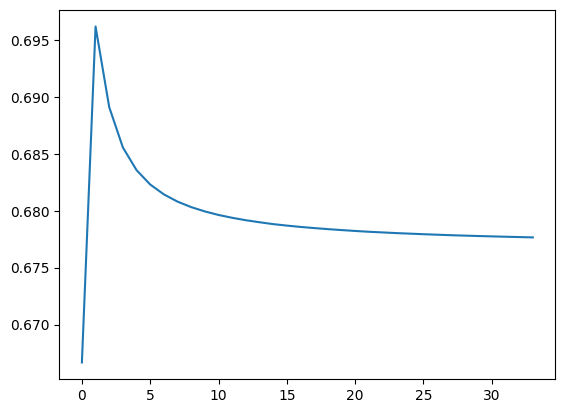

In [14]:
import matplotlib.pyplot as plt

chsh_f_ = expression_to_truth_table((x & y & z) | (x & y & ~w) | (x & z & ~w) | (y & z & ~w) | (w & ~x & ~y & ~z))
#chsh_f_ = expression_to_truth_table((w & x & ~y) | (w & x & ~z) | (y & z & ~w) | (y & z & ~x))

chsh_g = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]

#chsh_f_ = expression_to_truth_table((w&x) | (w&y) | (w&z)|(x&y) | (x&z) | (y&z) )
#chsh_g = expression_to_truth_table((~w&x&y&z)|(w&~x&y&z)|(w&x&~y&z)|(w&x&y&~z))

#etat = w_state
A = list(range(0,100,3))
R = []
for k in A:
    inter = []
    for i in range(3):

        best_quantum = find_best_quantum_strategy(chsh_f_, chsh_g, La4(k))
        score_quantum = 1 - best_quantum.fun
        inter.append(score_quantum)
            
    minterms = evaluate(chsh_f_) 
    #print(SOPform([w, x, y, z], minterms))
    #print(chsh_f_)
    #print("Best quantum :", score_quantum)
    #score,strategies = find_best_classical_strategies(chsh_f_, chsh_g)
    #print("Best classical :", score)
    #print("Angles")
    #angles = np.reshape(best_quantum.x, (n, 2, 3))
    #print(angles)
    R.append(max(inter))

    #print("----------------")
plt.plot(R)

In [45]:
A = np.linspace(-9,9,11)
B = np.linspace(9,-9,11)

#chsh_f_ = expression_to_truth_table((w&x) | (w&y) | (w&z)|(x&y) | (x&z) | (y&z) )
#chsh_g = expression_to_truth_table((~w&x&y&z)|(w&~x&y&z)|(w&x&~y&z)|(w&x&y&~z))


chsh_f_ = expression_to_truth_table((x & y & z) | (x & y & ~w) | (x & z & ~w) | (y & z & ~w) | (w & ~x & ~y & ~z))
chsh_g = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]

# Initialize result list
r = []

Z = np.zeros((len(A), len(B)))


# Loop over all points in the grid
for i, a in enumerate(A):
    for j, b in enumerate(B):
        inter = []
        for k in range(4):
            best_quantum = find_best_quantum_strategy(chsh_f_, chsh_g, Lab3(a,b))
            score_quantum = 1 - best_quantum.fun
            inter.append(score_quantum)
        Z[i, j] = max(inter)
        print(f"a={a}, b={b}", end="\r")

# Create meshgrid



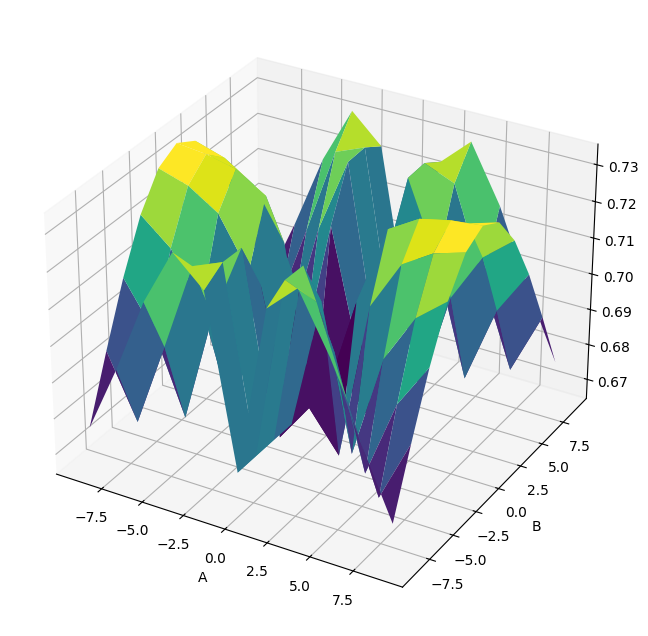

In [46]:
import matplotlib.pyplot as plt



X, Y = np.meshgrid(A, B)

# Create 3D plot
fig = plt.figure(figsize=(12, 8))  # Increase the size of the figure
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z.T, cmap='viridis')  # Note the transpose of Z


ax.set_xlabel('A')
ax.set_ylabel('B')

plt.show()

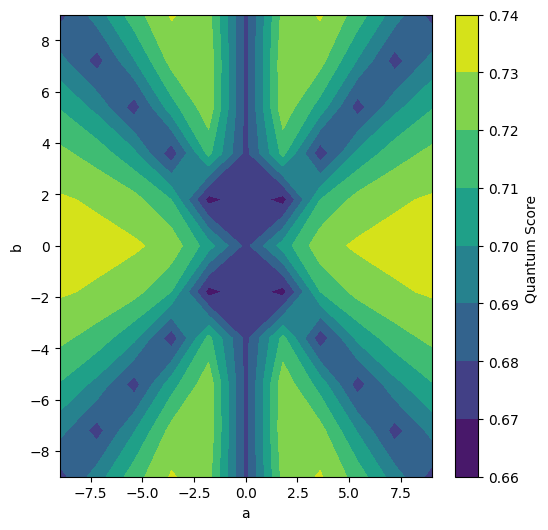

In [47]:
# Create meshgrid
X, Y = np.meshgrid(A, B)

# Create 2D contour plot
plt.figure(figsize=(6, 6))  # Increase the size of the figure
contour = plt.contourf(X, Y, Z.T, cmap='viridis')  # Note the transpose of Z
plt.colorbar(contour, label='Quantum Score ')  # Add colorbar for reference

plt.xlabel('a')
plt.ylabel('b')

plt.show()